# HOMEWORK 13

In this homework you are going to inspect the GTSDB (German Traffic Sign Detection Benchmark) dataset. The dataset contains images of various classes of traffic signs used in Germany (and the whole EU). The objective of this homework is to go through the steps described below and to implement the necessary code.

At the end, as usual, there will be a couple of questions for you to answer. In addition, the last section of this homework is optional and, if you chose to do it, you'll earn extra point :-)

In [79]:
import os
import cv2
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

### Step 0

Go to the GTSRB dataset official site ([link](https://benchmark.ini.rub.de/gtsrb_dataset.html)) to learn more about the dataset.

### Step 1

Download the dataset ([link](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign)) and unzip it.

### Step 2

For this homework, you will be working with the training set. Check out the `Train.csv`, open it and see what it contains. Load the dataset and plot random samples.

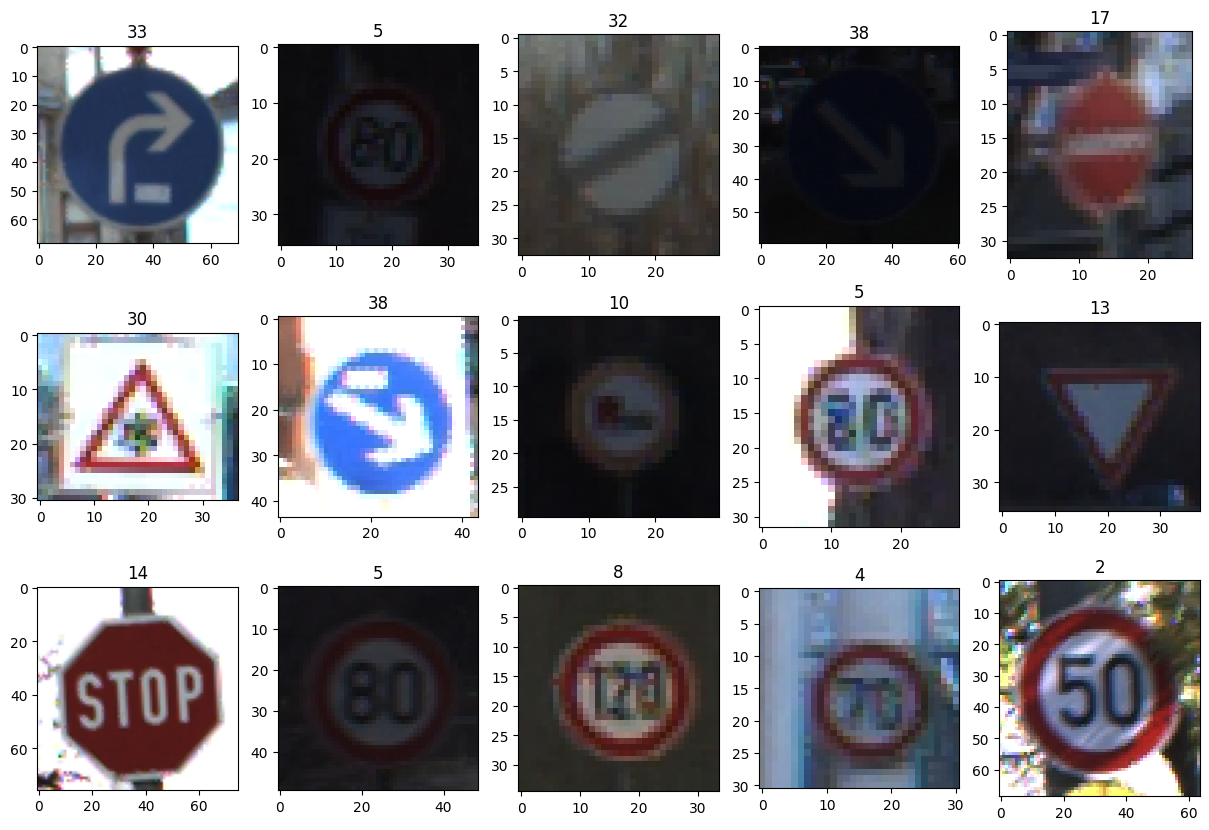

In [80]:
# Load the training labels
root = '../data/gtsrb' # Path to the dataset location, e.g., '/data/janko/dataset/GTSRB'
data = pd.read_csv(os.path.join(root, 'Train.csv'))

# Number of training samples (amount of samples in data)
num_samples = 39209

# Show random data samples
for ii in range(15):
    # Get random index
    idx = np.random.randint(0, num_samples)
    # Load image
    img = cv2.imread(os.path.join(root, data.iloc[idx]['Path']))
    # Convert image to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Show image
    plt.subplot(3,5,ii+1), plt.imshow(img), plt.title(data.iloc[idx]['ClassId'])

### Step 3

Inspect the dataset by computing and plotting the per-class histogram.

In [81]:
from collections import Counter
# Extract class identifiers
# Hint: Check the csv 
ids = data['ClassId']
len(ids.unique())

43

Compute the per class histogram. You can use any approach you want (e.g. `numpy`). It's also worth looking at the `Counter` function from the `collections` module ([link](https://docs.python.org/3/library/collections.html#collections.Counter)) ;-)

(Text(0.5, 0, 'Traffic Sign ID'), Text(0, 0.5, 'Counts'))

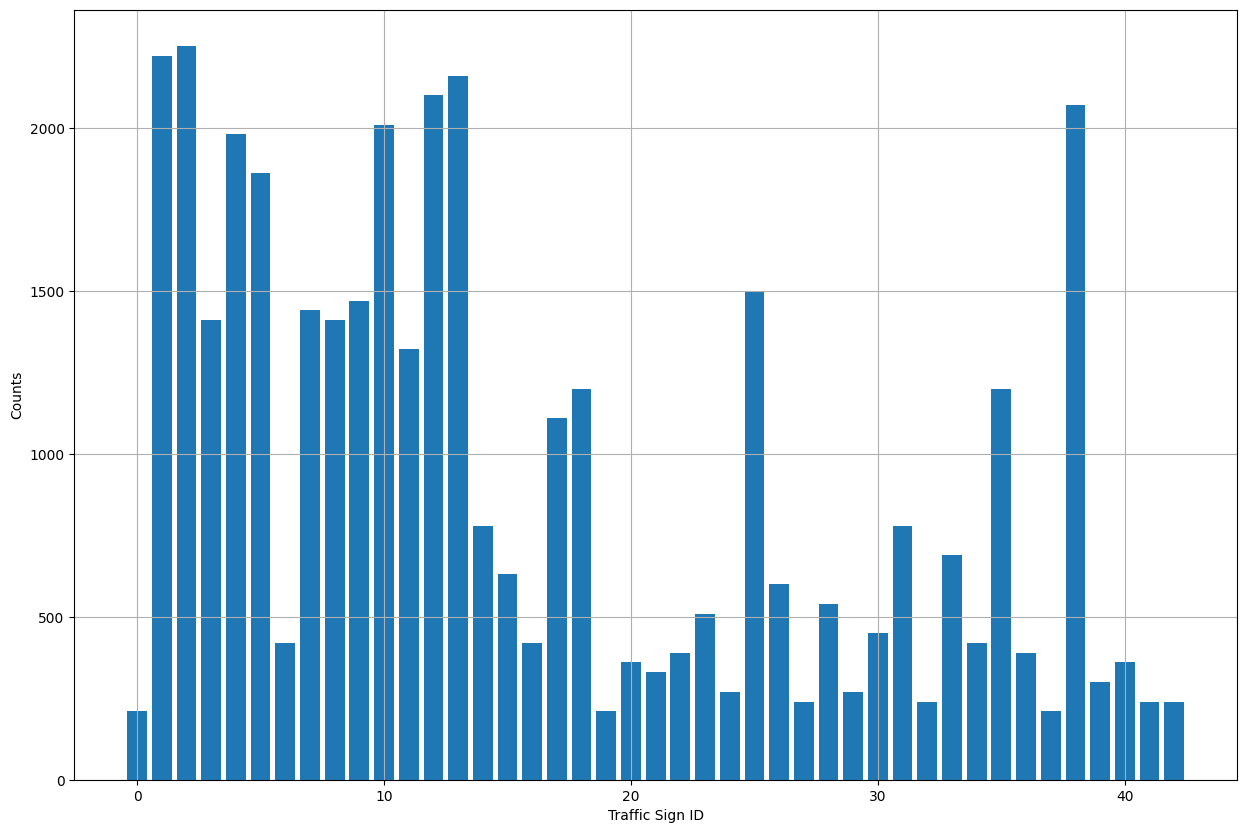

In [82]:
from collections import Counter
hist = Counter(ids)

plt.bar(hist.keys(), hist.values()), plt.grid(True)
plt.xlabel('Traffic Sign ID'), plt.ylabel('Counts')

### Questions

Please answer the following questions:
* Do you consider the dataset to be balanced? If so, why? If not, why?
* Are there any classes that are (significantly) over-represented or under-represeneted?

### Answers
- No, it's not balanced, some classes are represented by ~ 250 examples (and that is about 10/43 classes) and some are represented by 2000 (7/43 classes)
- I would probably be reasonable to cut the number of examples in each class to 250 or apply some kind of stratification on training.

### Optional

Perform a further analysis on the dataset and draw some conclusion from it.

Hint 1: Unlike MNIST or CIFAR10, this dataset contains images with various spatial resolutions. Is there anything we can tell about the resolution distribution?
Hint 2: What about the brightness distribution? Are there classes there are significantly more bright than others?

**In the dataset description it says that the resolution varies from 15px to 300px, and images are not always square. Also it says that there is always some margin ~10% between edge of the image and road sign. And the sign is not always centered.**

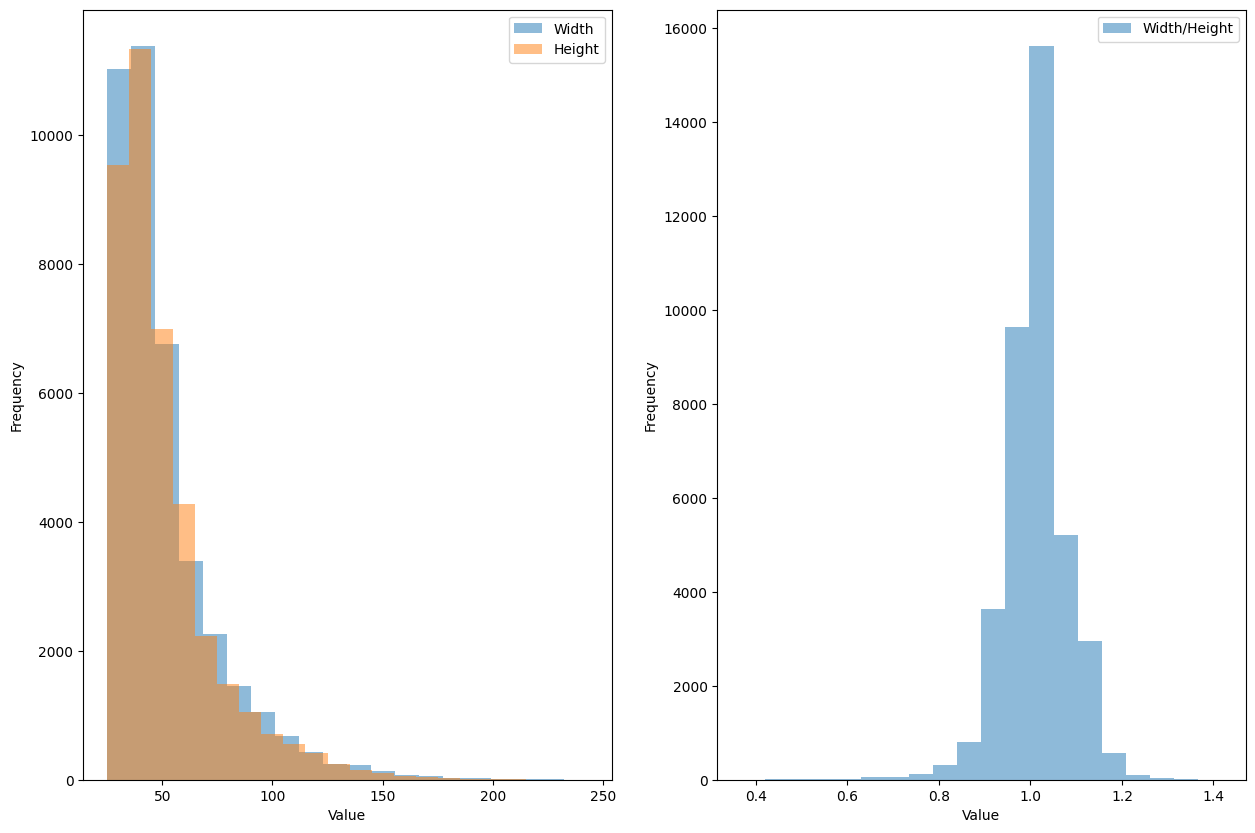

In [83]:
plt.subplot(121)
plt.hist(data['Width'], bins=20, alpha=0.5, label='Width')
plt.hist(data['Height'], bins=20, alpha=0.5, label='Height')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(122)
plt.hist(data['Width']/data['Height'], bins=20, alpha=0.5, label='Width/Height')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend();

**Really, resolution varies a lot, a most of the examples are under 50px, so we might consider that as an input size. Also, often the images are slightly unquare, so probably we should crop them by roi coordinates.**

In [84]:

# Calculate the squareness of the bounding box
data['Squareness'] = (data['Roi.X2'] - data['Roi.X1']) / (data['Roi.Y2'] - data['Roi.Y1'])

correlation = data['Squareness'].corr(data['Width'] / data['Height'])
print(correlation)

0.946422909762314


**Also, image proportions strongly correlate with bbox proportions but that should not be a problem. Let's try to calculate new bboxes that are square and contain original bboxes**

In [85]:
# Calculate the width and height of the original bounding box
width = data['Roi.X2'] - data['Roi.X1']
height = data['Roi.Y2'] - data['Roi.Y1']

# Determine the size of the square crop
crop_size = np.maximum(width, height)
crop_size = np.vectorize(lambda x: x + 1 if x % 2 == 1 else x)(crop_size)

# Calculate the center coordinates of the original bounding box
center_x = (data['Roi.X1'] + data['Roi.X2']) // 2
center_y = (data['Roi.Y1'] + data['Roi.Y2']) // 2

# Calculate the new bounding box coordinates
new_x1 = center_x - crop_size / 2
new_y1 = center_y - crop_size / 2
new_x2 = center_x + crop_size / 2
new_y2 = center_y + crop_size / 2

# Shift the new bounding box coordinates if they exceed the image boundaries
shift_x1 = np.maximum(-new_x1, 0)
new_x1 += shift_x1
new_x2 += shift_x1
shift_y1 = np.maximum(-new_y1, 0)
new_y1 += shift_y1
new_y2 += shift_y1
shift_x2 = np.maximum(new_x2 - data['Width'], 0)
new_x1 -= shift_x2
new_x2 -= shift_x2
shift_y2 = np.maximum(new_y2 - data['Height'], 0)
new_y1 -= shift_y2
new_y2 -= shift_y2

# Adjust the new bounding box coordinates if they exceed the image boundaries
new_x1 = np.maximum(new_x1, 0)
new_y1 = np.maximum(new_y1, 0)
new_x2 = np.minimum(new_x2, data['Width'])
new_y2 = np.minimum(new_y2, data['Height'])

# Update the bounding box coordinates in the dataframe
data['NewRoi.X1'] = new_x1
data['NewRoi.Y1'] = new_y1
data['NewRoi.X2'] = new_x2
data['NewRoi.Y2'] = new_y2

In [86]:
unsquare_mask = ((data['NewRoi.X2'] - data['NewRoi.X1']) / (data['NewRoi.Y2'] - data['NewRoi.Y1'])) != 1.0
data[unsquare_mask]

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,Squareness,NewRoi.X1,NewRoi.Y1,NewRoi.X2,NewRoi.Y2
356,71,59,6,5,65,54,20,Train/20/00020_00011_00026.png,1.204082,5.0,0.0,65.0,59.0
765,55,67,5,6,50,61,1,Train/1/00001_00006_00015.png,0.818182,0.0,5.0,55.0,61.0
766,57,70,5,7,52,64,1,Train/1/00001_00006_00016.png,0.824561,0.0,6.0,57.0,64.0
1434,64,80,5,8,59,73,1,Train/1/00001_00028_00024.png,0.830769,0.0,7.0,64.0,73.0
1482,37,49,5,6,31,43,1,Train/1/00001_00030_00012.png,0.702703,0.0,5.0,37.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37584,73,116,6,10,67,106,38,Train/38/00038_00052_00025.png,0.635417,0.0,10.0,73.0,106.0
37585,75,119,7,11,69,109,38,Train/38/00038_00052_00026.png,0.632653,0.0,11.0,75.0,109.0
37586,75,120,6,10,69,110,38,Train/38/00038_00052_00027.png,0.630000,0.0,10.0,75.0,110.0
37587,77,121,7,10,71,111,38,Train/38/00038_00052_00028.png,0.633663,0.0,9.0,77.0,111.0


**So, after cropping there are 435 rows that cannot be square and contain the original bbox at the same time. So I'd suggest dropping them**

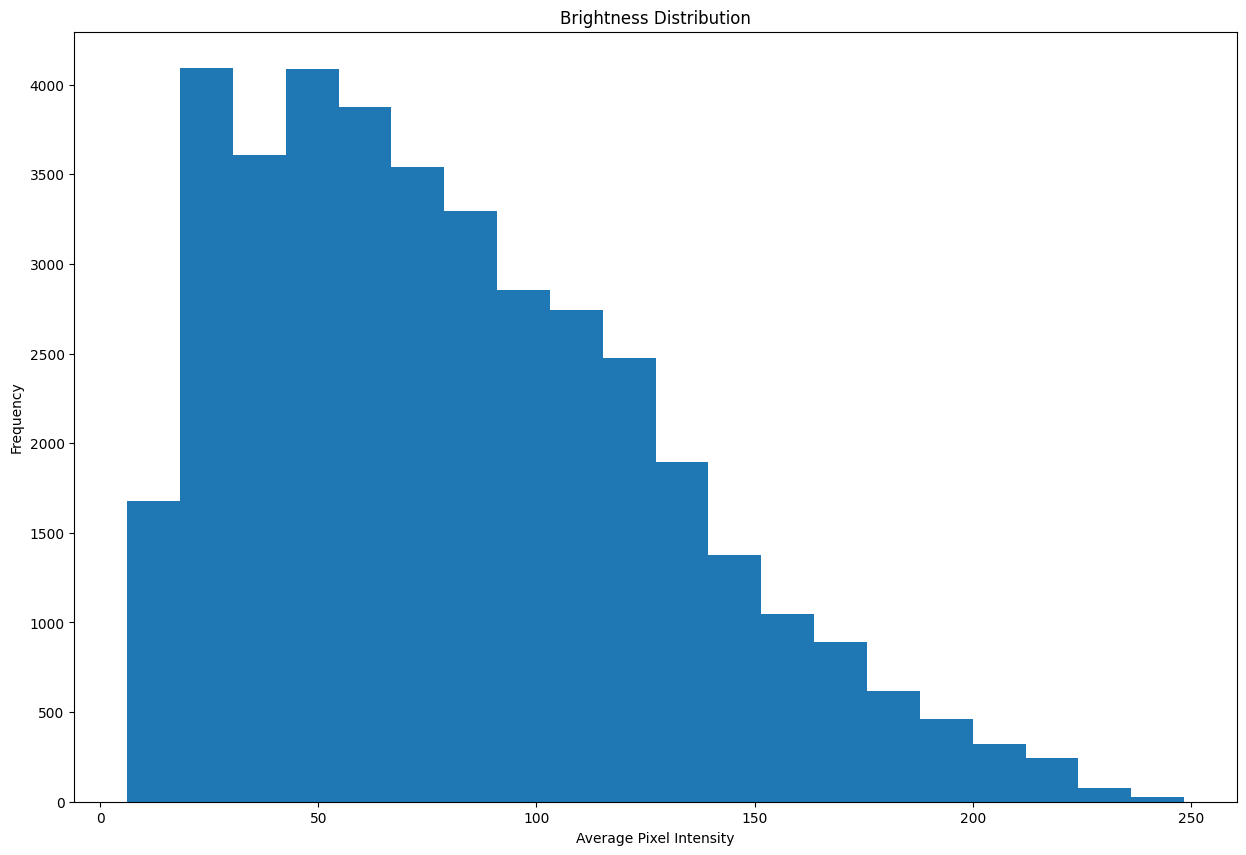

In [87]:
# Create an empty list to store the average pixel intensities
avg_intensities = []

# Loop through the images
for idx in range(num_samples):
    # Read the image
    img = cv2.imread(os.path.join(root, data.iloc[idx]['Path']))
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the average pixel intensity
    avg_intensity = np.mean(gray_img)
    # Append the average intensity to the list
    avg_intensities.append(avg_intensity)

# Plot the histogram of average pixel intensities
plt.hist(avg_intensities, bins=20)
plt.xlabel('Average Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Brightness Distribution')
plt.show()


**The average brigness is also unbalanced: about half of the images are dark and some of them are marginally dark. I would apply some preprocessing to equalize the data. Or at least make sure that we are doing standardization of neural network inputs.**